<a href="https://colab.research.google.com/github/enelene/Walmart-Recruiting---Store-Sales-Forecasting/blob/main/model_experiment_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
# Add the directory containing your script to the Python path
sys.path.append('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main')

In [ ]:
!pip install -r  drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import mlflow
import mlflow.pyfunc
import optuna
import os
import dagshub

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
# from src.preprocessing import advanced_feature_engineering

In [ ]:
def wmae(y_true, y_pred, is_holiday):
    """Computes the Weighted Mean Absolute Error."""
    weights = np.where(np.array(is_holiday, dtype=bool), 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)


In [ ]:
try:
    train_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/train_final.csv', parse_dates=['Date'])
    validation_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/validation_final.csv', parse_dates=['Date'])
    test_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/test_final.csv', parse_dates=['Date'])
    print("Successfully loaded all pre-split data files.")
except KeyError:
    print("ERROR: Make sure you have uploaded all three required CSV files.")
    raise

Successfully loaded all pre-split data files.


In [ ]:
import dagshub

dagshub.init(repo_owner='enelene', repo_name='Walmart-Recruiting---Store-Sales-Forecasting', mlflow=True)

Accessing as enelene

Initialized MLflow to track repo "enelene/Walmart-Recruiting---Store-Sales-Forecasting"

Repository enelene/Walmart-Recruiting---Store-Sales-Forecasting initialized!

In [ ]:
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow")

os.environ['MLFLOW_TRACKING_USERNAME'] = 'enelene'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cbe8109dbe80931664d754dbd476356414fa62a0'

EXPERIMENT_NAME = "LightGBM_Training"
print(f"Experiment set to: '{EXPERIMENT_NAME}'")


Experiment set to: 'LightGBM_Training'


In [ ]:
# Define Features (X) and Target (y)
TARGET = 'Weekly_Sales'
FEATURES_TO_DROP = [TARGET, 'Date']
initial_features = [col for col in train_df.columns if col not in FEATURES_TO_DROP]

# Define categorical features based on our knowledge of the data
categorical_features_initial = [
    'Store', 'Dept', 'IsHoliday', 'Year', 'Month', 'WeekOfYear', 'HasMarkdown',
    'Store_Dept', 'Type_A', 'Type_B', 'Type_C', 'IsSuperBowlWeek',
    'IsLaborDayWeek', 'IsThanksgivingWeek', 'IsChristmasWeek'
]
categorical_features_initial = [f for f in categorical_features_initial if f in train_df.columns]


In [ ]:
# Convert categorical features to the correct dtype for LightGBM
for col in categorical_features_initial:
    train_df[col] = train_df[col].astype('category')

In [ ]:
dagshub.init(repo_owner='enelene', repo_name='Walmart-Recruiting---Store-Sales-Forecasting', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow")

os.environ['MLFLOW_TRACKING_USERNAME'] = 'enelene'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cbe8109dbe80931664d754dbd476356414fa62a0'

EXPERIMENT_NAME = "LightGBM_Advanced_Training"
mlflow.set_experiment(EXPERIMENT_NAME)
print(f"MLflow experiment set to: '{EXPERIMENT_NAME}'")

# Custom evaluation metric (WMAE) required by the competition
def wmae(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday.astype(bool), 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

Initialized MLflow to track repo "enelene/Walmart-Recruiting---Store-Sales-Forecasting"

Repository enelene/Walmart-Recruiting---Store-Sales-Forecasting initialized!

MLflow experiment set to: 'LightGBM_Advanced_Training'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

--- Training a baseline model for feature selection ---
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6988
[LightGBM] [Info] Number of data points in the train set: 203988, number of used features: 35
[LightGBM] [Info] Start training from score 17609.587572


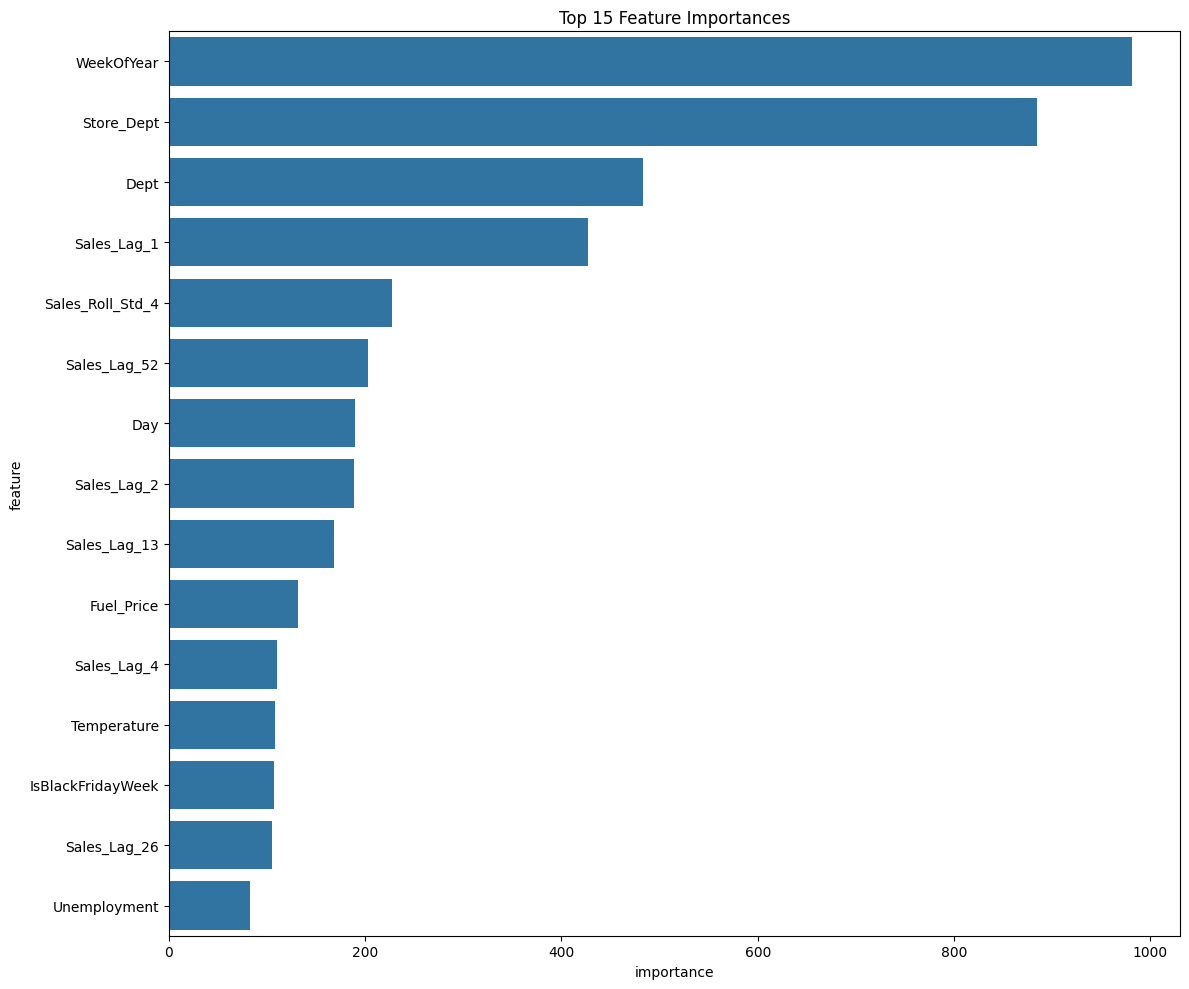


Selected top 15 features.
🏃 View run Feature_Selection at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4/runs/e7bd59b6c47b48c1bdb63f430dd14083
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
with mlflow.start_run(run_name="Feature_Selection") as run:
    print("--- Training a baseline model for feature selection ---")

    X_initial = train_df[initial_features]
    y = train_df[TARGET]

    # Use a simple TimeSeriesSplit for this preliminary step
    tscv = TimeSeriesSplit(n_splits=2)
    train_idx, val_idx = list(tscv.split(X_initial))[-1] # Use the last split

    X_train, X_val = X_initial.iloc[train_idx], X_initial.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train a simple model
    model_for_fs = lgb.LGBMRegressor(random_state=42, n_estimators=500)
    model_for_fs.fit(X_train, y_train,
                     eval_set=[(X_val, y_val)],
                     eval_metric='mae',
                     callbacks=[lgb.early_stopping(50, verbose=False)],
                     categorical_feature=categorical_features_initial)

    # --- Create and Log Feature Importance Plot ---
    feature_importances = pd.DataFrame({
        'feature': X_initial.columns,
        'importance': model_for_fs.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()

    # Log the plot to MLflow
    mlflow.log_figure(plt.gcf(), "feature_importance_top15.png")
    plt.show()

    # --- Select Top N Features ---
    NUM_FEATURES_TO_SELECT = 15
    selected_features = feature_importances['feature'].head(NUM_FEATURES_TO_SELECT).tolist() + ['IsHoliday']
    print(f"\nSelected top {NUM_FEATURES_TO_SELECT} features.")

    # Log the list of selected features as a text file artifact
    with open("selected_features.txt", "w") as f:
        for feature in selected_features:
            f.write(f"{feature}\n")
    mlflow.log_artifact("selected_features.txt")

# Prepare final feature set for the main experiment
X = train_df[selected_features]
categorical_features = [f for f in categorical_features_initial if f in selected_features]

In [ ]:
categorical_features_initial

['Store',
 'Dept',
 'IsHoliday',
 'Year',
 'Month',
 'WeekOfYear',
 'HasMarkdown',
 'Store_Dept',
 'Type_A',
 'Type_B',
 'Type_C',
 'IsSuperBowlWeek',
 'IsLaborDayWeek',
 'IsChristmasWeek']

In [ ]:
selected_features

['WeekOfYear',
 'Store_Dept',
 'Dept',
 'Sales_Lag_1',
 'Sales_Roll_Std_4',
 'Sales_Lag_52',
 'Day',
 'Sales_Lag_2',
 'Sales_Lag_13',
 'Fuel_Price',
 'Sales_Lag_4',
 'Temperature',
 'IsBlackFridayWeek',
 'Sales_Lag_26',
 'Unemployment',
 'IsHoliday']

In [ ]:
print(categorical_features)

['Dept', 'IsHoliday', 'WeekOfYear', 'Store_Dept']


In [ ]:
def objective(trial):
    """Optuna objective function using the selected features."""
    params = {
        'objective': 'regression_l1', 'metric': 'mae', 'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'verbose': -1, 'n_jobs': -1, 'seed': 42
    }

    wmae_scores = []
    tscv = TimeSeriesSplit(n_splits=3)
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='mae',
                  callbacks=[lgb.early_stopping(100, verbose=False)],
                  categorical_feature=categorical_features)

        preds = model.predict(X_val)
        is_holiday_val = X_val['IsHoliday']
        score = wmae(y_val, preds, is_holiday_val)
        wmae_scores.append(score)

    return np.mean(wmae_scores)


In [ ]:

# Start a new parent run for the main experiment
with mlflow.start_run(run_name="LGBM_Tuning_and_Final_Model") as run:
    print("--- Starting Hyperparameter Tuning with Optuna (using selected features) ---")
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10)

    best_params = study.best_params
    best_wmae = study.best_value

    print(f"\nBest WMAE from tuning: {best_wmae:.4f}")
    print(f"Best Parameters: {best_params}")


    mlflow.log_params(best_params)
    mlflow.log_metric("best_cv_wmae", best_wmae)

    # --- Log Optuna plots as artifacts ---
    fig_optuna_history = optuna.visualization.plot_optimization_history(study)
    mlflow.log_figure(fig_optuna_history, "optuna_optimization_history.html")

    fig_optuna_slice = optuna.visualization.plot_slice(study)
    mlflow.log_figure(fig_optuna_slice, "optuna_slice_plot.html")

[I 2025-08-02 10:28:04,602] A new study created in memory with name: no-name-1a4c4cc4-ab08-49f2-a3e7-1772fa3e8556


--- Starting Hyperparameter Tuning with Optuna (using selected features) ---


[I 2025-08-02 10:32:04,783] Trial 0 finished with value: 2278.653103119584 and parameters: {'learning_rate': 0.021202451558359155, 'num_leaves': 84, 'feature_fraction': 0.6127085503343073, 'bagging_fraction': 0.99790035165274, 'bagging_freq': 6, 'lambda_l1': 0.00044951558602197546, 'lambda_l2': 2.6086450631833635}. Best is trial 0 with value: 2278.653103119584.
[I 2025-08-02 10:35:56,080] Trial 1 finished with value: 2303.144001749508 and parameters: {'learning_rate': 0.049923038201688474, 'num_leaves': 47, 'feature_fraction': 0.6563151666493799, 'bagging_fraction': 0.6051900092057146, 'bagging_freq': 5, 'lambda_l1': 0.0013769108711300614, 'lambda_l2': 0.3759067804547095}. Best is trial 0 with value: 2278.653103119584.
[I 2025-08-02 10:38:34,212] Trial 2 finished with value: 2380.6421793397603 and parameters: {'learning_rate': 0.03709659049699002, 'num_leaves': 81, 'feature_fraction': 0.9583295205643841, 'bagging_fraction': 0.8547583550917326, 'bagging_freq': 4, 'lambda_l1': 4.15683555


Best WMAE from tuning: 2248.6149
Best Parameters: {'learning_rate': 0.04570319600062117, 'num_leaves': 34, 'feature_fraction': 0.6439703127865368, 'bagging_fraction': 0.9594936279484765, 'bagging_freq': 6, 'lambda_l1': 0.4218424794663666, 'lambda_l2': 0.03359858547081948}
🏃 View run LGBM_Tuning_and_Final_Model at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4/runs/d1b24c60485b452197ad381a570441cc
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
best_params = study.best_params
best_wmae = study.best_value
print(best_params, best_wmae)

{'learning_rate': 0.04570319600062117, 'num_leaves': 34, 'feature_fraction': 0.6439703127865368, 'bagging_fraction': 0.9594936279484765, 'bagging_freq': 6, 'lambda_l1': 0.4218424794663666, 'lambda_l2': 0.03359858547081948} 2248.6148607564105


In [ ]:
mlflow.end_run()


--- Performing Final Hold-out Validation ---
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6439703127865368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6439703127865368
[LightGBM] [Warning] lambda_l2 is set=0.03359858547081948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03359858547081948
[LightGBM] [Warning] lambda_l1 is set=0.4218424794663666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4218424794663666
[LightGBM] [Warning] bagging_fraction is set=0.9594936279484765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9594936279484765
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=6, s

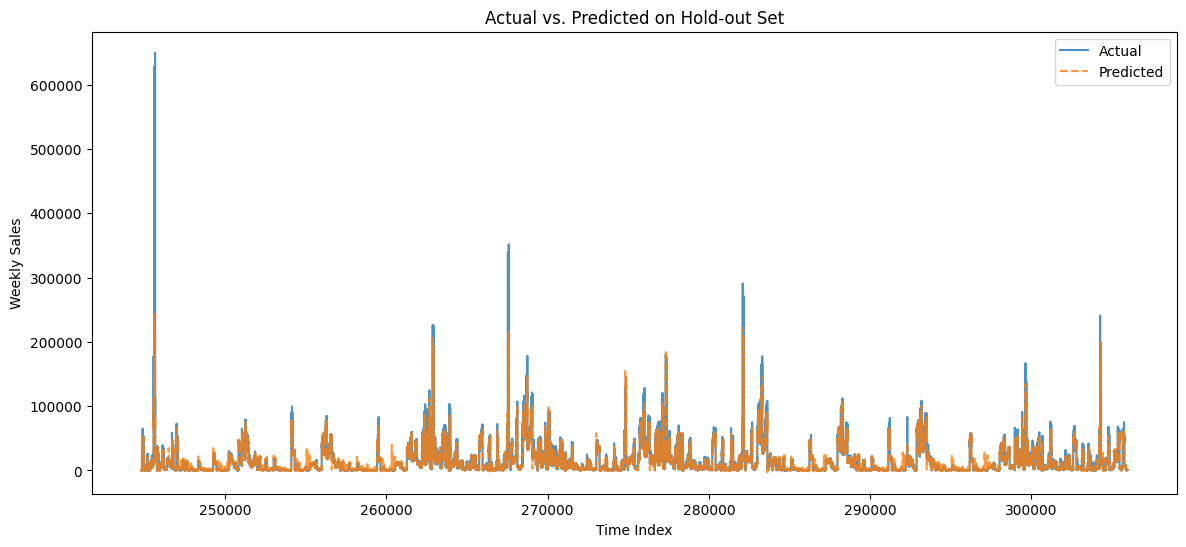

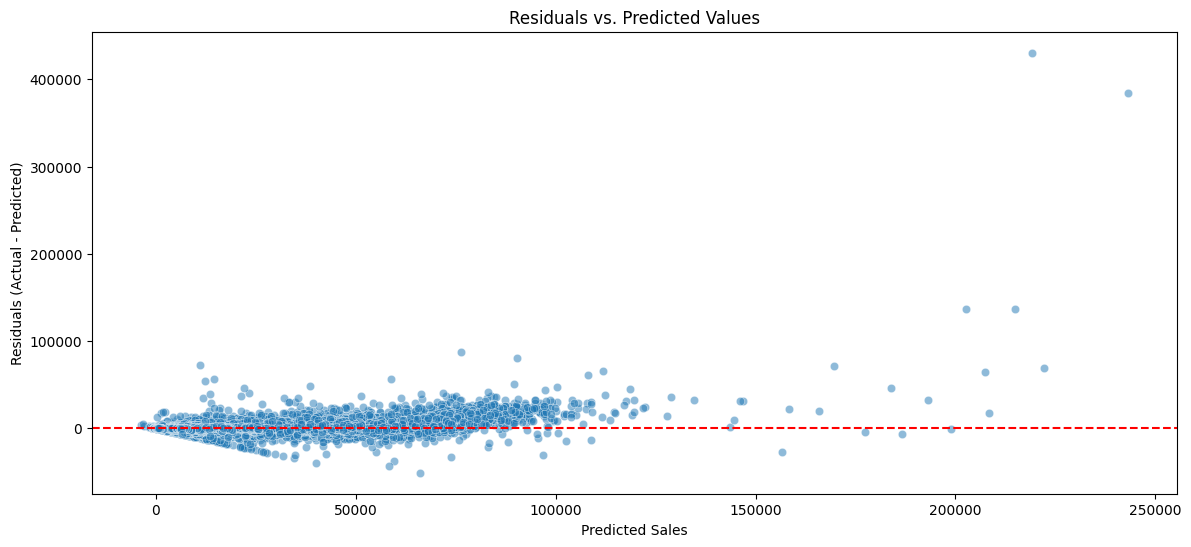


--- Training Final Model on ALL Data for Deployment ---
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6439703127865368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6439703127865368
[LightGBM] [Warning] lambda_l2 is set=0.03359858547081948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03359858547081948
[LightGBM] [Warning] lambda_l1 is set=0.4218424794663666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4218424794663666
[LightGBM] [Warning] bagging_fraction is set=0.9594936279484765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9594936279484765
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq 

In [ ]:
# Continue within the same parent MLflow run
with mlflow.start_run(run_id=run.info.run_id):
    # --- Final Hold-out Validation ---
    print("\n--- Performing Final Hold-out Validation ---")
    tscv_final = TimeSeriesSplit(n_splits=4)
    train_idx, val_idx = list(tscv_final.split(X))[-1] # Use the very last fold as a hold-out set

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    final_params = best_params
    final_params['n_estimators'] = 3000 # Use more estimators
    final_params['random_state'] = 42

    model_for_validation = lgb.LGBMRegressor(**final_params)
    model_for_validation.fit(X_train, y_train,
                             eval_set=[(X_val, y_val)],
                             callbacks=[lgb.early_stopping(150, verbose=False)],
                             categorical_feature=categorical_features)

    val_preds = model_for_validation.predict(X_val)

    # Calculate and log final validation metrics
    final_wmae = wmae(y_val, val_preds, X_val['IsHoliday'])
    final_mae = mean_absolute_error(y_val, val_preds)
    final_rmse = np.sqrt(mean_squared_error(y_val, val_preds))

    print(f"Final Hold-out WMAE: {final_wmae:.4f}")
    print(f"Final Hold-out MAE:  {final_mae:.4f}")
    print(f"Final Hold-out RMSE: {final_rmse:.4f}")

    mlflow.log_metrics({
        "final_holdout_wmae": final_wmae,
        "final_holdout_mae": final_mae,
        "final_holdout_rmse": final_rmse
    })

    # --- Create and Log Analysis Plots ---
    # Actual vs. Predicted Plot
    plt.figure(figsize=(14, 6))
    plt.plot(y_val.index, y_val, label='Actual', alpha=0.8)
    plt.plot(y_val.index, val_preds, label='Predicted', alpha=0.8, linestyle='--')
    plt.title('Actual vs. Predicted on Hold-out Set')
    plt.xlabel('Time Index')
    plt.ylabel('Weekly Sales')
    plt.legend()
    mlflow.log_figure(plt.gcf(), "actual_vs_predicted.png")
    plt.show()

    # Residuals Plot
    residuals = y_val - val_preds
    plt.figure(figsize=(14, 6))
    sns.scatterplot(x=val_preds, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Residuals (Actual - Predicted)')
    mlflow.log_figure(plt.gcf(), "residuals_plot.png")
    plt.show()

    # --- Train Final Model on All Data ---
    print("\n--- Training Final Model on ALL Data for Deployment ---")
    final_model = lgb.LGBMRegressor(**final_params)
    final_model.fit(X, y, categorical_feature=categorical_features)
    print("Final model training complete.")

In [ ]:
# Continue within the same parent MLflow run
with mlflow.start_run(run_id=run.info.run_id):

    # We need to save the category mappings from the training data
    training_categories = {
        col: X[col].cat.categories for col in categorical_features if hasattr(X[col], 'cat')
    }

    # Define the custom pyfunc model class (no changes here)
    class WalmartSalesPipeline(mlflow.pyfunc.PythonModel):
        def __init__(self, model, training_columns, categories):
            self.model = model
            # self._feature_engineering_fn = feature_engineering_fn
            self._training_columns = training_columns
            self._categories = categories

        def predict(self, context, model_input):
            # 1. Apply the same feature engineering as in training
            processed_input = model_input

            # 2. Enforce consistent categories to handle new or unseen values
            for col, cats in self._categories.items():
                if col in processed_input.columns:
                    processed_input[col] = pd.Categorical(processed_input[col], categories=cats, ordered=False)

            # 3. Ensure all training columns are present and in the correct order, fill missing with 0
            processed_input = processed_input.reindex(columns=self._training_columns, fill_value=0)

            # 4. Predict
            return self.model.predict(processed_input)

    print("\n--- Logging and Registering Final Model Pipeline ---")

    # Instantiate the pipeline
    pipeline_instance = WalmartSalesPipeline(final_model, selected_features, training_categories)


/usr/local/lib/python3.11/dist-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning:

Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.




--- Logging and Registering Final Model Pipeline ---
🏃 View run LGBM_Tuning_and_Final_Model at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4/runs/d1b24c60485b452197ad381a570441cc
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
X

,WeekOfYear,Store_Dept,Dept,Sales_Lag_1,Sales_Roll_Std_4,Sales_Lag_52,Day,Sales_Lag_2,Sales_Lag_13,Fuel_Price,Sales_Lag_4,Temperature,IsBlackFridayWeek,Sales_Lag_26,Unemployment,IsHoliday
0,5,1_1,1,24924.50,12832.106391,24924.50,5,24924.50,24924.50,2.572,24924.50,42.31,0,24924.50,8.106,False
1,6,1_1,1,24924.50,12832.106391,24924.50,12,24924.50,24924.50,2.548,24924.50,38.51,0,24924.50,8.106,True
2,7,1_1,1,46039.49,12832.106391,24924.50,19,24924.50,24924.50,2.514,24924.50,39.93,0,24924.50,8.106,False
3,8,1_1,1,41595.55,12832.106391,24924.50,26,46039.49,24924.50,2.561,24924.50,46.63,0,24924.50,8.106,False
4,9,1_1,1,19403.54,12832.106391,24924.50,5,41595.55,24924.50,2.625,24924.50,46.50,0,24924.50,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305977,52,45_98,98,1084.78,257.116069,74.55,30,853.46,727.05,3.389,538.51,37.79,0,1005.98,8.523,True
305978,1,45_98,98,553.21,252.920722,122.50,6,1084.78,894.98,3.422,572.72,35.88,0,1021.94,8.424,False
305979,2,45_98,98,698.76,227.367911,42.00,13,553.21,996.40,3.513,853.46,41.18,0,1033.14,8.424,False
305980,3,45_98,98,677.71,229.929744,2.00,20,698.76,1058.84,3.533,1084.78,31.85,0,614.73,8.424,False


In [ ]:
signature=mlflow.models.infer_signature(X, final_model.predict(X))

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.6439703127865368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6439703127865368
[LightGBM] [Warning] lambda_l2 is set=0.03359858547081948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03359858547081948
[LightGBM] [Warning] lambda_l1 is set=0.4218424794663666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4218424794663666
[LightGBM] [Warning] bagging_fraction is set=0.9594936279484765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9594936279484765


/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



In [ ]:
print(signature)

inputs: 
  ['WeekOfYear': long (required), 'Store_Dept': string (required), 'Dept': long (required), 'Sales_Lag_1': double (required), 'Sales_Roll_Std_4': double (required), 'Sales_Lag_52': double (required), 'Day': long (required), 'Sales_Lag_2': double (required), 'Sales_Lag_13': double (required), 'Fuel_Price': double (required), 'Sales_Lag_4': double (required), 'Temperature': double (required), 'IsBlackFridayWeek': long (required), 'Sales_Lag_26': double (required), 'Unemployment': double (required), 'IsHoliday': boolean (required)]
outputs: 
  [Tensor('float64', (-1,))]
params: 
  None



In [ ]:
print("Step 1: Logging model pipeline as an artifact...")
model_info = mlflow.lightgbm.log_model(
      lgb_model=final_model,
      artifact_path="lightgbm-model",
      signature=signature)
print("LightGBM model artifact logged successfully.")

# Step 2: Register the logged model artifact to the Model Registry.
model_uri = model_info.model_uri
registered_model_name = "LightGBM-Walmart-Sales"

print(f"Step 2: Registering model from '{model_uri}' to '{registered_model_name}'...")
mlflow.register_model(
    model_uri=model_uri,
    name=registered_model_name
)

# Add descriptive tags to the run
mlflow.set_tag("model_type", "LightGBM")
mlflow.set_tag("project", "Walmart Sales Forecasting")
mlflow.set_tag("features", f"selected_top_{NUM_FEATURES_TO_SELECT}")

print("\n✅ Model Pipeline successfully logged and registered to DagsHub/MLflow!")

Step 1: Logging model pipeline as an artifact...
LightGBM model artifact logged successfully.
Step 2: Registering model from 'runs:/fb0ac2b29d8a4fd49db30d36558a0613/lightgbm-model' to 'LightGBM-Walmart-Sales'...


Registered model 'LightGBM-Walmart-Sales' already exists. Creating a new version of this model...
2025/08/02 12:01:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM-Walmart-Sales, version 3
Created version '3' of model 'LightGBM-Walmart-Sales'.



✅ Model Pipeline successfully logged and registered to DagsHub/MLflow!


In [ ]:
logged_model_uri = f"runs:/fb0ac2b29d8a4fd49db30d36558a0613/lightgbm-model"

In [ ]:
print(logged_model_uri)

runs:/d4ba4736aa78443b883440a0fb023399/lightgbm-model


In [ ]:
logged_model_uri = f"runs:/d4ba4736aa78443b883440a0fb023399/lightgbm-model"
loaded_pipeline = mlflow.pyfunc.load_model(logged_model_uri)

In [ ]:

# --- Load Raw Test Data ---
print("\n--- Generating Submission File ---")
# Assuming test_df is already loaded and preprocessed if necessary
# test_df = pd.read_csv(...)

# --- Load the Packaged Pipeline Model from MLflow ---
# FIX: Use the correct artifact_path "lightgbm-model" that you used when logging.
logged_model_uri = logged_model_uri
loaded_pipeline = mlflow.pyfunc.load_model(logged_model_uri)
print(f"✅ Model loaded successfully from: {logged_model_uri}")

test_df = test_df[selected_features]
test_predictions = loaded_pipeline.predict(test_df, categorical_features)


# --- Create Submission File ---
submission_df = test_df.copy()
submission_df['Weekly_Sales'] = test_predictions

# Clip predictions at 0, as sales cannot be negative
submission_df['Weekly_Sales'] = submission_df['Weekly_Sales'].clip(lower=0)

# Create the required 'Id' column
submission_df['Id'] = submission_df['Store'].astype(str) + '_' + submission_df['Dept'].astype(str) + '_' + submission_df['Date'].dt.strftime('%Y-%m-%d')

# Select and save the final columns
final_submission = submission_df[['Id', 'Weekly_Sales']]

# Define a local path to save the file
submission_path = 'submission.csv'
final_submission.to_csv(submission_path, index=False)
print("\nSubmission file created locally.")
display(final_submission.head())

# --- Log Submission File as an Artifact ---
mlflow.log_artifact(submission_path, "submission")
print("\nSubmission file logged to MLflow artifacts.")
print(f"✅ Experiment complete! Find your run at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting/experiments/#/{run.info.experiment_id}/{run.info.run_id}")


--- Generating Submission File ---


2025/08/02 12:04:31 WARNING mlflow.models.utils: `params` can only be specified at inference time if the model signature defines a params schema. This model does not define a params schema. Ignoring invalid params (not a dictionary).


✅ Model loaded successfully from: runs:/fb0ac2b29d8a4fd49db30d36558a0613/lightgbm-model


ValueError: train and valid dataset categorical_feature do not match.